# Revision II

The better understand our recommendation and gain confidence, we use another model and see
if recommendations change.

In [7]:
from itertools import product

from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

COLORS = {'TV': '#1b9e77',
          'radio': '#d95f02',
          'newspaper': '#7570b3', 
          'total': '#c51b8a'}

platform_names = ['TV', 'radio', 'newspaper']
total_name = 'total'
sales_name = 'sales'

In [8]:
def plot_coefficients(coef, names):
    importance = pd.Series(coef, index=names, name='coef')
    fig, ax = plt.subplots()
    importance.plot.bar(ax=ax)
    ax.set_title('Coefficients')

    
def create_model_explorer(df, model):

    def explore_budget_plan(tv_budget=140, radio_budget=20, newspaper_budget=30):
        planned_budged = np.array([[tv_budget, radio_budget, newspaper_budget]])

        sales_pred = model.predict(planned_budged)

        fig, axs = plt.subplots(figsize=(14, 6), ncols=3, sharey=True)
        for xname, ax in zip(xnames, axs):
            df.plot.scatter(ax=ax, x=xname, y=yname, color=COLORS[xname])

        for budget, ax in zip(planned_budged[0], axs):
            ax.scatter(budget, sales_pred, color='k', s=800, marker='+')
            # TODO add vlines and hlines
    
    return explore_budget_plan  
 

def generate_valid_budget_allocations(total_budget):
    
    budget_options = range(0, total_budget + 1, 2)
    
    budget_allocations = []
    for budget_allocation in product(budget_options, budget_options, budget_options):
        if sum(budget_allocation) != total_budget:
            continue
        budget_allocations.append(budget_allocation)
    return np.array(budget_allocations)

# Load

In [22]:
# read in the data
df = pd.read_csv('http://faculty.marshall.usc.edu/gareth-james/ISL/Advertising.csv', index_col=0)
df.head(3)

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3


# Model

1. Chose a model
1. Select hyperparameter
  - Grid seach
  - Cross validation
1. Evaluate

In [23]:
xnames = platform_names
yname = sales_name

X = df[xnames]
y = df[yname]

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# a random forest requires little tuning
# still, we vary n_estimators to include CV in this final example
# and step through the entire process
param_grid = {'n_estimators': [50, 100, 200]}

grid_search_cv = GridSearchCV(RandomForestRegressor(oob_score=True), 
                              param_grid=param_grid, 
                              cv=10, 
                              return_train_score=True, 
                              n_jobs=3)
grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(oob_score=True), n_jobs=3,
             param_grid={'n_estimators': [50, 100, 200]},
             return_train_score=True)

In [25]:
# observe that, as noted above (random forest requires little tuning), changing the parameter had little impact
print('params', grid_search_cv.cv_results_['params'])
print('mean_test_score', grid_search_cv.cv_results_['mean_test_score'])

params [{'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 200}]
mean_test_score [0.96749726 0.96712232 0.96745273]


In [26]:
model = grid_search_cv.best_estimator_
model.fit(X_train, y_train)  # for use in evaluation
# we skip this part, cf. the previous notebooks

RandomForestRegressor(n_estimators=50, oob_score=True)

In [28]:
model = grid_search_cv.best_estimator_
model.fit(X, y)  # for use in production
# we use this final model to support our decision making

RandomForestRegressor(n_estimators=50, oob_score=True)

## Discuss

### Q&A: Investment in which channel is most valuable?

We can take a look at feature importance. The larger the value, the more important the model
considers the variable.

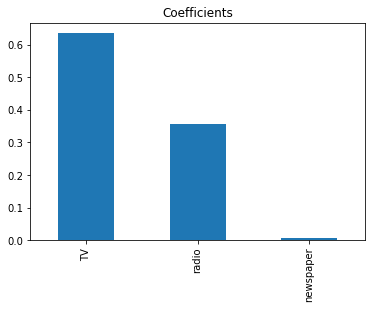

In [29]:
plot_coefficients(model.feature_importances_, xnames)

### Q&A: How to optimally distribute additional resources?

Procedure:
1. Compute a range of different budget plans.
1. Make a prediction of each budget plan.
1. Assess the result.
1. Pick the plan with the largest increase in sales.

---

*You already know this part.*

In [30]:
total_extra_budget = 20
extra_budget_allocations = generate_valid_budget_allocations(total_extra_budget)
extra_budget_allocations[:3]

array([[ 0,  0, 20],
       [ 0,  2, 18],
       [ 0,  4, 16]])

#### Status Quo

In [31]:
status_quo = df[xnames + [yname]].mean().to_frame().T
status_quo  # this is where we are on average (budget-wise)

,TV,radio,newspaper,sales
0,147.0425,23.264,30.554,14.0225


#### Possible Budget Plans

In [32]:
current_budget = status_quo[xnames].values
possible_budget_plans = current_budget + extra_budget_allocations
sales_pred = model.predict(possible_budget_plans)

In [33]:
plan = pd.DataFrame(possible_budget_plans, columns=xnames)
plan['sales'] = sales_pred
plan.head(3)

,TV,radio,newspaper,sales
0,147.0425,23.264,50.554,14.624
1,147.0425,25.264,48.554,14.992
2,147.0425,27.264,46.554,15.948


#### Assessment

Compute impact of different budget plans on sales.

In [34]:
absolute_difference = plan - status_quo.values
absolute_difference.sort_values('sales', ascending=False).head(5)

,TV,radio,newspaper,sales
10,0.0,20.0,0.0,4.7935
29,4.0,16.0,0.0,4.1495
20,2.0,18.0,0.0,4.1155
9,0.0,18.0,2.0,3.9835
19,2.0,16.0,2.0,3.7695


In [35]:
relative_difference = (plan - status_quo.values)/status_quo.values
relative_difference.sort_values('sales', ascending=False).head(5).style.format("{:.2%}")

,TV,radio,newspaper,sales
10,0.00%,85.97%,0.00%,34.18%
29,2.72%,68.78%,0.00%,29.59%
20,1.36%,77.37%,0.00%,29.35%
9,0.00%,77.37%,6.55%,28.41%
19,1.36%,68.78%,6.55%,26.88%


#### Decision

Spend the entire additional budget on radio.

# Concluding Remarks

- There are a range of different search strategies to chose
  hyperparameters. For us, using a grid search is fine.
- The model itself is a hyperparameter is well. In this class, 
  it is sufficient to change it manually.
- Random forests are popular *off the shelve* models. They are easy
  to use and often provide a good base line.
- Ideally, the decision making process is modelled in a way that 
  different models can be plugged in as needed. As we did above.

# Follow Up Questions & Exercises

- How does the feature importance estimation compare between the random forest and 
  the linear model with polynomial terms?
- How does a tree based model behave out of data (compared to the linear model)?